In [18]:
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import precision_score
import pandas as pd
import copy

In [2]:
class stockpredictor:
  def __init__(self,ticker,vol=False):
    self.ticker=ticker
    self.model=RandomForestClassifier(n_estimators=500,min_samples_split=50,random_state=1)
    self.predictors=[]
    self.data=None
    self.getdata()
    self.vol=vol
    self.dressdata()

  def getdata(self):
    self.data=yf.Ticker(self.ticker).history(period="max")
    self.data['Tomorrow']=self.data.shift(-1)['Close']
    self.data['Target']=(self.data['Tomorrow']>self.data['Close']).astype(int)
    self.data=self.data.dropna()

  def dressdata(self):
    averagewindow=[2,10,50,100,400,1000]
    self.predictors=[]
    for h in averagewindow:
      ravg=self.data.rolling(h).mean()

      ratio=f"CloseRatio_{h}"
      self.data[ratio]=self.data['Close']/ravg['Close']

      trend=f"Trend_{h}"
      self.data[trend]=self.data.shift(1).rolling(h).sum()['Target']

      volatility=f"Volat_{h}"
      self.data[volatility]= np.log((((self.data["Close"]-ravg["Close"])**2).rolling(h).sum()/h)**0.5)
      if self.vol:
        self.predictors +=[ratio,trend,volatility]
      else:
        self.predictors +=[ratio,trend]
    self.data.replace([np.inf, -np.inf], np.nan, inplace=True)

    self.data=self.data.dropna()

  def Predict(self,train,test):
    self.model.fit(train[self.predictors],train["Target"])
    predicts=self.model.predict_proba(test[self.predictors])[:,1]

    predicts[predicts>=0.6]=1
    predicts[predicts<0.6]=0

    return pd.concat([test["Target"],pd.Series(predicts,index=test.index,name="Predictions")],axis=1)

  def backtest(self,start=2500,step=250):
    allpredict=[]
    for i in range(start,self.data.shape[0],step):
      train,test=self.data.iloc[0:i].copy(),self.data.iloc[i:i+step].copy()
      predicts=self.Predict(train,test)
      allpredict.append(predicts)
    return pd.concat(allpredict)

  def result(self,data):
    return self.model.predict_proba(data[self.predictors])[:,1]

  def plotter(self,predictions):
    Yearu=[[],[]]
    Yeard=[[],[]]
    UP=[[],[]]
    DOWN=[[],[]]
    dd=[]
    dc=[]
    pid=predictions.index
    data=self.data
    for j in range(2):
      val='Target' if j==0 else 'Predictions'

      for i in range(len(pid)):
        temp=predictions.iloc[i][val]
        if temp==0:
          Yeard[j].append(pid[i])
          DOWN[j].append(data.loc[pid[i]]['Close'])
        else:
          Yearu[j].append(pid[i])
          UP[j].append(data.loc[pid[i]]['Close'])
        "sad"
        if j==0:
          dd.append(pid[i])
          dc.append(data.loc[pid[i]]['Close'])
    for j in range(2):
     plt.subplot(1,2,j+1)
     plt.scatter(Yeard[j],DOWN[j],color='red',alpha=0.5,s=0.125)
     #plt.scatter(dd,dc,alpha=0.1,s=0.1)
     plt.scatter(Yearu[j],UP[j],color='green',alpha=0.5,s=0.12)
     plt.title(self.ticker+": " +('Target' if j==0 else 'Prediction; '+f"Volatility:{self.vol}"))

     plt.grid(which='major')
    plt.show()
    print("Red: Went-down; Green: Went-up; precision = {}".format(precision_score(predictions['Target'],predictions['Predictions'])))


In [33]:
class newstock(stockpredictor):
  def __init__(self,ticker):
    super().__init__(ticker)

  def getROI(self,window):
    #Returns ROI of stock in window-size(time) investment over historical data
    data=copy.deepcopy(self.data)

    data['next']=data.shift(-window)['Close']
    data['ROI']=((data["next"]-data['Close'])*100/data['Close'])
    data.dropna(inplace=True)
    ROI=copy.deepcopy(data['ROI'].to_list())
    index=copy.deepcopy(data.index.to_list())
    del data
    return (ROI,index)

In [44]:
def mycopy(stuff):
  return copy.deepcopy(stuff)

In [99]:
class Portfolio:
  def __init__(self,tickerlist):
    self.stocklist=copy.deepcopy(tickerlist)
    self.stocks=[newstock(ticker) for ticker in tickerlist]


  def getstatus(self):
    current={}

    for stock in self.stocks:
      close=stock.data['Close'].to_list()[-1]
      window=[10,100,1000]
      volat=[]
      ROI=[]
      for win in window:
        volat.append(mycopy(stock.data[f'Volat_{win}'].to_list()[-1]))
        roi,_=stock.getROI(win)
        ROI.append(roi[-1])
      current[stock.ticker]=mycopy((close,volat,ROI,window))

    return current

  def printstatus(self):
    currentstatus=self.getstatus()
    window=currentstatus[self.stocklist[0]][3]
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    voltx=''.join([f'Volatility({win}) :::::' for win in window])
    rox=''.join([f'ROI({win}) :::::' for win in window])
    print(f"TICKER ::::: CLOSE :::::"+voltx+rox)
    print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
    for stock in self.stocklist:
      voltx=''.join([f'{str(i)} :::::' for i in currentstatus[stock][1]])
      rox=''.join([f'{str(i)} :::::' for i in currentstatus[stock][2]])
      print(f"{stock} ::::: {currentstatus[stock][0]} ::::: "+voltx+rox)

  def plotROI(self,win):
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(2, 2)
    c=0
    for stock in self.stocks:
      if c>=4:
        break
      i,j=c//2,c%2
      roi,time=stock.getROI(win)
      ax[i,j].plot(time,roi,label=stock.ticker)
      ax[i,j].legend()
      ax[i,j].grid(which='major')
      ax[i,j].set(ylabel=f'ROI_{win}')
      c=c+1
    return

  def plothist(self,col):
    if "ROI" in col:
      win=int(col.split('_')[1])
      self.plotROI(win)
      return
    plt.rcParams.update({'font.size': 7})
    fig, ax = plt.subplots(2, 2)
    c=0
    for stock in self.stocks:
      if c>=4:
        break
      i,j=c//2,c%2
      ax[i,j].plot(stock.data.index,stock.data[col],label=stock.ticker)
      ax[i,j].legend()
      ax[i,j].grid(which='major')
      ax[i,j].set(ylabel=col)
      c=c+1



In [100]:
port=Portfolio(["GOOG","SBUX","^GSPC","SPELS.BO"])

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [101]:
port.stocks[0].data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,CloseRatio_2,...,Volat_50,CloseRatio_100,Trend_100,Volat_100,CloseRatio_400,Trend_400,Volat_400,CloseRatio_1000,Trend_1000,Volat_1000
Date,,,,,,,,,,,,,,,,,,,,,
2012-07-25 00:00:00-04:00,15.151210,15.277237,15.077735,15.142990,73193322,0.0,0.0,15.276739,1,1.000345,...,-0.465375,1.009111,50.0,-0.483027,1.044206,207.0,0.208156,1.184900,516.0,0.721252
2012-07-26 00:00:00-04:00,15.317586,15.364161,15.193800,15.276739,67660662,0.0,0.0,15.814723,1,1.004397,...,-0.453911,1.018039,51.0,-0.482531,1.053388,208.0,0.204977,1.195053,517.0,0.721559
2012-07-27 00:00:00-04:00,15.414473,15.815719,15.379853,15.814723,142520206,0.0,0.0,15.748471,0,1.017303,...,-0.417637,1.053365,52.0,-0.474220,1.090332,209.0,0.202912,1.236800,517.0,0.722023
2012-07-30 00:00:00-04:00,15.841871,16.005009,15.678732,15.748471,87795852,0.0,0.0,15.765158,1,0.997901,...,-0.386689,1.048509,51.0,-0.467424,1.085608,209.0,0.201019,1.231304,516.0,0.722363
2012-07-31 00:00:00-04:00,15.647848,15.853079,15.646852,15.765158,74903709,0.0,0.0,15.757935,0,1.000529,...,-0.362857,1.049170,51.0,-0.460532,1.086609,209.0,0.199017,1.232296,516.0,0.722692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-24 00:00:00-05:00,139.539993,139.677002,137.470001,138.220001,8828600,0.0,0.0,138.050003,0,0.993531,...,1.661759,1.046227,56.0,2.377837,1.225290,201.0,3.015985,1.290358,542.0,3.622639
2023-11-27 00:00:00-05:00,137.570007,139.630005,137.539993,138.050003,17886400,0.0,0.0,138.619995,1,0.999385,...,1.639861,1.043588,56.0,2.373377,1.223382,200.0,3.017857,1.287910,541.0,3.622872
2023-11-28 00:00:00-05:00,137.630005,138.660004,137.039993,138.619995,17046900,0.0,0.0,136.399994,0,1.002060,...,1.616710,1.046435,57.0,2.370095,1.227913,201.0,3.019831,1.292364,541.0,3.623109


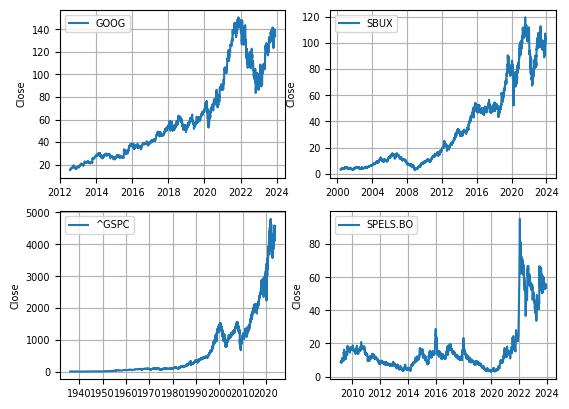

In [102]:
columns=["Close","Volat_10","Volat_100","Volat_1000","ROI_10","ROI_100","ROI_1000"]
ch=0
port.plothist(columns[ch])

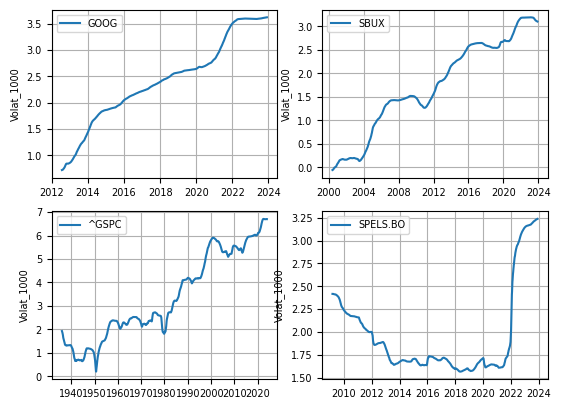

In [103]:
port.plothist(columns[3])

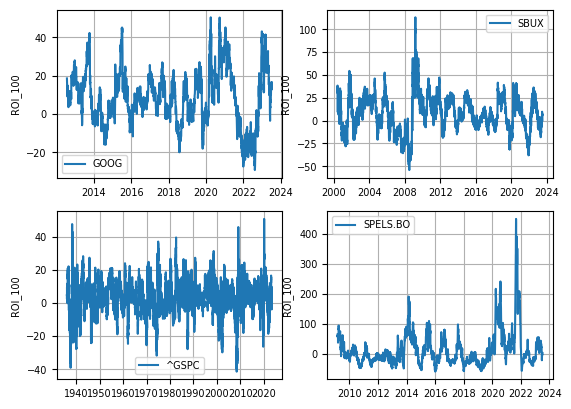

In [109]:
port.plothist(columns[-2])

In [3]:
def compareVolatilityfeature(ticker):

  stock1=stockpredictor(ticker)
  p1=stock1.backtest()

  stock2=stockpredictor(ticker,True)
  p2=stock2.backtest()

  stock1.plotter(p1)
  stock2.plotter(p2)

  print(">>>>>>>>>> WITHOUT VOLATILITY")
  print(">>>>>>>>>> WITH VOLATILITY")

In [110]:
    """Healthcare: Moderna (MRNA), Pfizer (PFE), Johnson & Johnson (JNJ)

    Tech: Google (GOOGL), Facebook (FB), Apple (AAPL)

    Retail: Costco (COST), Walmart (WMT),  Kroger Co (KR)

    Finance: JPMorgan Chase & Co (JPM), Bank of America (BAC), HSBC Holding (HSBC)"""

'Healthcare: Moderna (MRNA), Pfizer (PFE), Johnson & Johnson (JNJ)\n\nTech: Google (GOOGL), Facebook (FB), Apple (AAPL)\n\nRetail: Costco (COST), Walmart (WMT),  Kroger Co (KR)\n\nFinance: JPMorgan Chase & Co (JPM), Bank of America (BAC), HSBC Holding (HSBC)'

In [106]:
#compareVolatilityfeature("GOOG")

In [107]:
#compareVolatilityfeature("SBUX")

In [ ]:
#datasp500

def Predict(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])
  predicts=pd.Series(model.predict(test[predictors]),index=test.index,name="Predictions")
  combined=pd.concat([test["Target"],predicts],axis=1)
  return combined

def Predictcustom(train,test,predictors,model):
  model.fit(train[predictors],train["Target"])

  predicts=model.predict_proba(test[predictors])[:,1]#predict probability rather than up or down==> prob(goes down , 0) , prob(goes up,1)

  predicts[predicts>=0.6]=1
  predicts[predicts<0.6]=0#change predictions such that only when confidence greatere than 60%

  predicts=pd.Series(predicts,index=test.index,name="Predictions")
  combined=pd.concat([test["Target"],predicts],axis=1)
  return combined




def backtest(data,model,predictors,start=2500,step=250):#Train for 1 year(250 row) and then go to next and so on till 10 year(2500 row)
  all_predictions=[]

  for i in range(start,data.shape[0],step):
    train,test=data.iloc[0:i].copy(),data.iloc[i:i+step].copy()
    predictions=Predictcustom(train,test,predictors,model)
    all_predictions.append(predictions)
  return pd.concat(all_predictions)

In [ ]:
model=RandomForestClassifier(n_estimators=100,min_samples_split=100, random_state=1)


predictors=["Close","Volume","High","Low","Open"]#columns used to predict target(ie will price go up or down tomorrow)

#model.fit(train[predictors],train["Target"])

In [ ]:
#preds=pd.Series(model.predict(test[predictors]),index=test.index)

In [ ]:
#preds,test['Target']
#precision_score(test['Target'],preds)

In [ ]:
#combined=pd.concat([test["Target"],preds],axis=1)

In [ ]:
#combined.plot()

In [ ]:
predictions=backtest(data,model,predictors)
#predictions["Predictions"].value_counts()

In [ ]:
precision_score(predictions["Target"],predictions["Predictions"])

0.44

In [ ]:
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,NEXTUPDOWN,Target
Date,,,,,,,,,,
2001-04-19 00:00:00+05:30,3.650000,3.650000,3.650000,3.650000,200,0.0,0.0,3.650000,0,0
2001-04-20 00:00:00+05:30,3.650000,3.650000,3.650000,3.650000,0,0.0,0.0,3.650000,0,0
2001-04-23 00:00:00+05:30,3.650000,3.650000,3.650000,3.650000,0,0.0,0.0,3.650000,0,0
2001-04-24 00:00:00+05:30,3.650000,3.650000,3.650000,3.650000,0,0.0,0.0,3.650000,0,0
2001-04-25 00:00:00+05:30,3.650000,3.650000,3.650000,3.650000,0,0.0,0.0,3.650000,0,0
...,...,...,...,...,...,...,...,...,...,...
2023-10-09 00:00:00+05:30,56.500000,57.000000,54.000000,54.230000,49905,0.0,0.0,57.590000,1,1
2023-10-10 00:00:00+05:30,55.000000,58.000000,54.799999,57.590000,56009,0.0,0.0,58.009998,1,1
2023-10-11 00:00:00+05:30,59.900002,60.500000,57.009998,58.009998,48207,0.0,0.0,57.150002,0,0


In [ ]:
#lets add more predictors to rable ==> new relevant variables like rolling averages etc.
newpredictors=[]
rollhorizon=[2,10,70,300,800]#rolling averages over 2,10,70.... days
for horizon in rollhorizon:
  rollingaverage=data.rolling(horizon).mean()#calculate rolling average of all olumns over horizon days

  ratio=f"Close_Ratio_{horizon}"
  data[ratio]=data["Close"]/rollingaverage["Close"]#store ratio of current close price with rolling aveargae

  trend=f"Trend_{horizon}"
  data[trend]=data.shift(1).rolling(horizon).sum()["Target"]#at any day store how many days before it actually went up==> rolling over target

  newpredictors += [ratio,trend]


In [ ]:
#newpredictors
data=data.dropna()
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,NEXTUPDOWN,Target,Close_Ratio_2,Trend_2,Close_Ratio_10,Trend_10,Close_Ratio_70,Trend_70,Close_Ratio_300,Trend_300,Close_Ratio_800,Trend_800
Date,,,,,,,,,,,,,,,,,,,,
2004-05-13 00:00:00+05:30,7.010000,7.940000,6.610000,7.460000,118600,0.0,0.0,6.070000,0,0,0.992021,0.0,1.069841,6.0,1.572939,39.0,1.887238,142.0,1.854245,247.0
2004-05-14 00:00:00+05:30,7.500000,7.840000,5.970000,6.070000,76600,0.0,0.0,5.200000,0,0,0.897265,0.0,0.863442,5.0,1.270634,39.0,1.530728,142.0,1.507616,247.0
2004-05-17 00:00:00+05:30,5.550000,7.280000,4.870000,5.200000,31300,0.0,0.0,5.970000,1,1,0.922804,0.0,0.737589,5.0,1.085886,38.0,1.307979,142.0,1.290911,247.0
2004-05-18 00:00:00+05:30,4.180000,6.000000,4.180000,5.970000,28100,0.0,0.0,6.200000,1,1,1.068935,1.0,0.839072,5.0,1.241607,38.0,1.496741,143.0,1.480999,248.0
2004-05-19 00:00:00+05:30,6.000000,6.690000,6.000000,6.200000,64400,0.0,0.0,6.090000,0,0,1.018899,2.0,0.873609,5.0,1.281067,39.0,1.548967,144.0,1.536841,249.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-06 00:00:00+05:30,55.709999,57.189999,55.709999,56.529999,29592,0.0,0.0,54.230000,0,0,1.001151,1.0,0.997336,5.0,1.013409,28.0,1.098016,132.0,1.526596,390.0
2023-10-09 00:00:00+05:30,56.500000,57.000000,54.000000,54.230000,49905,0.0,0.0,57.590000,1,1,0.979234,1.0,0.961900,4.0,0.972930,28.0,1.053070,132.0,1.462077,389.0
2023-10-10 00:00:00+05:30,55.000000,58.000000,54.799999,57.590000,56009,0.0,0.0,58.009998,1,1,1.030048,1.0,1.019040,5.0,1.032364,29.0,1.117797,132.0,1.549928,390.0


In [ ]:
model=RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)
predictions=backtest(data,model,newpredictors)

In [ ]:
precision_score(predictions['Target'],predictions["Predictions"])#55% times when model predicted it'll go up(target) it did go up

0.6927374301675978

In [ ]:
predictions['Predictions'].sum(),predictions['Target'].sum()

(179.0, 1062)

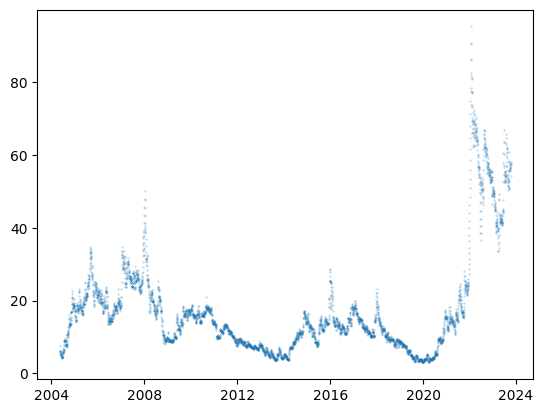

In [ ]:
plt.scatter(data.index,data['Close'],alpha=0.5,s=0.1)

In [ ]:
#data.loc[predictions.index[0]]['Close']


b


In [ ]:
def plotter(data,predictions):
  Yearu=[[],[]]
  Yeard=[[],[]]
  UP=[[],[]]
  DOWN=[[],[]]
  dd=[]
  dc=[]
  pid=predictions.index
  for j in range(2):
    val='Target' if j==0 else 'Predictions'

    for i in range(len(pid)):
      temp=predictions.iloc[i][val]
      if temp==0:
        Yeard[j].append(pid[i])
        DOWN[j].append(data.loc[pid[i]]['Close'])
      else:
        Yearu[j].append(pid[i])
        UP[j].append(data.loc[pid[i]]['Close'])
      "sad"
      if j==0:
        dd.append(pid[i])
        dc.append(data.loc[pid[i]]['Close'])
  for j in range(2):
    plt.subplot(1,2,j+1)
    plt.scatter(Yeard[j],DOWN[j],color='red',alpha=0.5,s=0.125)
    #plt.scatter(dd,dc,alpha=0.1,s=0.1)
    plt.scatter(Yearu[j],UP[j],color='green',alpha=0.5,s=0.12)
    plt.title('Target' if j==0 else 'Prediction')
    plt.grid(which='major')
  print(precision_score(predictions['Target'],predictions['Predictions']))

0.6927374301675978


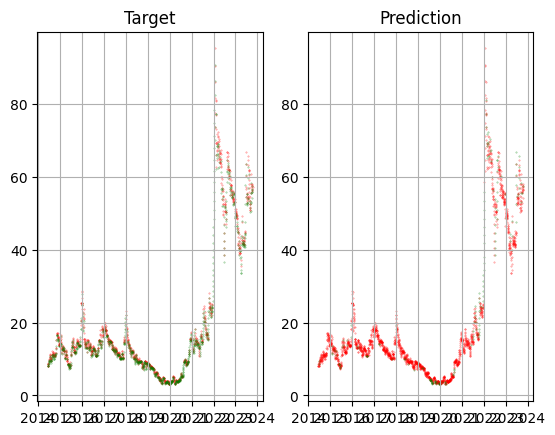

In [ ]:
plotter(data,predictions)

In [ ]:
temppp=data.iloc[2:3]
model.predict(temppp[newpredictors])#,temppp

array([0])

0.6


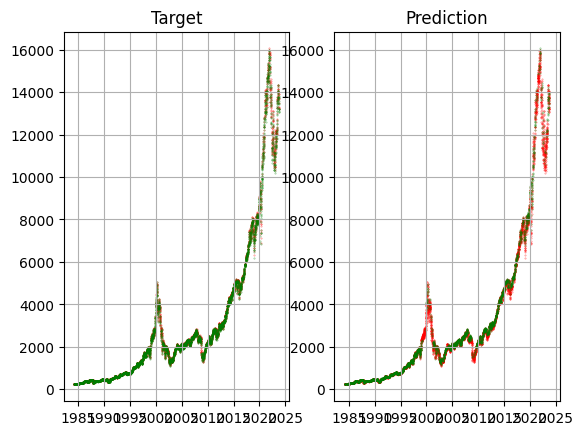

In [ ]:

dji=yf.Ticker("^IXIC")
djidata=dji.history(period="max")
djidata['Tomorrow']=djidata.shift(-1)['Close']
djidata['Target']= (djidata['Tomorrow']>djidata['Close']).astype(int)
dataj=djidata.dropna().copy()
#dataj


averagewindow=[2,10,50,100,400,800]
predictorsj=[]

for h in averagewindow:
  ravg=dataj.rolling(h).mean()

  ratio=f"Close_Ratio_{h}"
  dataj[ratio]=dataj["Close"]/ravg["Close"]

  trend=f"Trend_{h}"
  dataj[trend]=dataj.shift(1).rolling(h).sum()["Target"]

  predictorsj += [ratio,trend]

dataj=dataj.dropna()
modelj=RandomForestClassifier(n_estimators=200,min_samples_split=50,random_state=1)
predictionsj=backtest(dataj,modelj,predictorsj)

#predictionsj
plotter(dataj,predictionsj)